# Lab 5: Support Vector Machines and Decision Trees

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "lab5"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# SVM

## LinearSVC

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)


iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [4]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)



/Users/zhangyou036/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [6]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


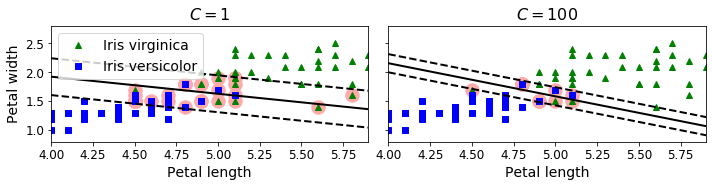

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

## Non-linear SVM with Gaussian RBF Kernel

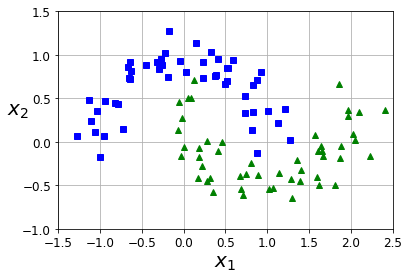

In [12]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Saving figure moons_rbf_svc_plot


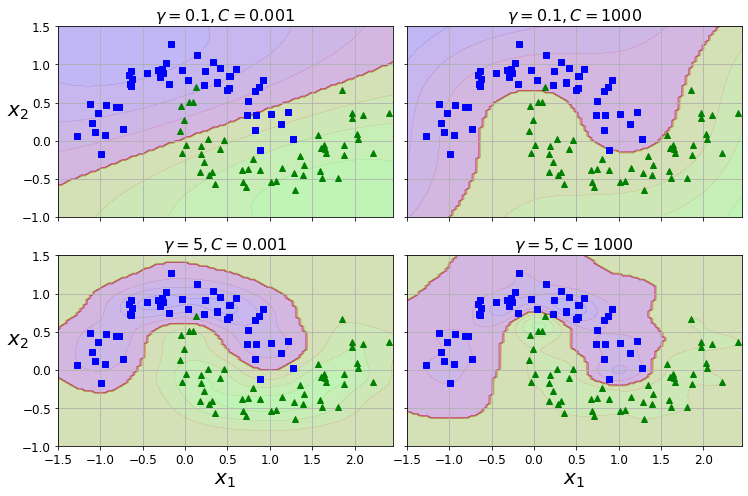

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

## Practice: 

_Exercise: train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._   Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [14]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [15]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28474532] [[1.05364923 1.09903601]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


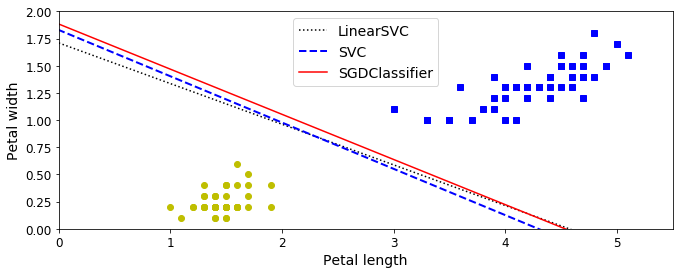

In [16]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

_Exercise: train an SVM regressor on the California housing dataset._

In [27]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

/Users/zhangyou036/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [29]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.976993881287582

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $10,000. Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   3.5s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   3.4s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   3.5s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   3.4s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   3.1s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   3.1s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   2.7s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   2.8s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc1861f050>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc38f9c7d0>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [31]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785359

In [33]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528734

# Decision Trees

## Training and Visualizing a Decision Tree

In [17]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Saving figure decision_tree_decision_boundaries_plot


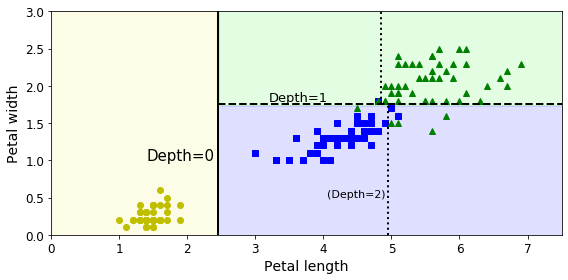

In [18]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

In [19]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [20]:
tree_clf.predict([[5, 1.5]])

array([1])

## Regularization using min_samples_leaf

Saving figure min_samples_leaf_plot


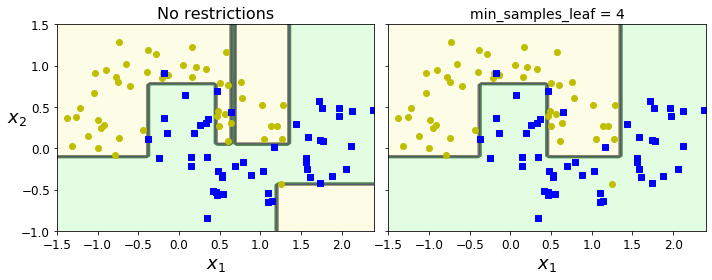

In [22]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

## Regression

In [23]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

Saving figure tree_regression_regularization_plot


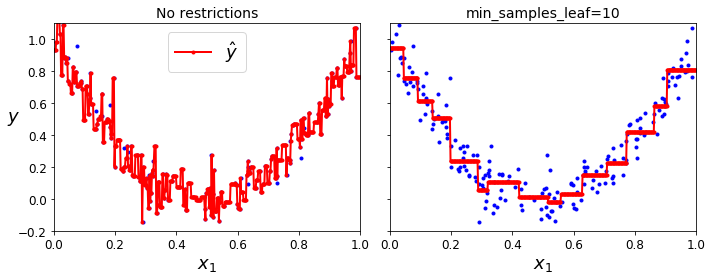

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()